In [ ]:
import nltk
import string
import tensorflow
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras.models import Model
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
nltk.download('punkt','stopwords')
warnings.filterwarnings("ignore")
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [2]:

features = pd.read_csv(r"D:\Machine Learning\Music Emotion Prediction\data\static_features.csv")
target = pd.read_csv(r"D:\Machine Learning\Music Emotion Prediction\data\static_annotations_std.csv")
lyrics = pd.read_csv(r"D:\Machine Learning\Music Emotion Prediction\data\lrc_dataset.csv")

print(features.shape)
print(target.shape)
print(lyrics.shape)


(794, 6374)
(767, 3)
(601, 4)


In [3]:

data = pd.merge(features, target, on=['musicId'])
print(data.shape)
data.head(2)


(767, 6376)


,musicId,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,...,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,Arousal(std),Valence(std)
0,1,7.318236,0.716432,0.0,2.245124,3.145057,3.956726,0.899933,0.811669,1.711601,...,2.884782,2.886936,-1339.063,0.554930,113.5535,57.37954,111.6133,59.35901,0.156125,0.160078
1,4,6.558082,0.703399,0.0,1.606873,2.116417,2.917487,0.509543,0.801071,1.310614,...,2.659783,2.660821,-2561.713,0.665665,104.4877,63.52283,106.1832,54.71746,0.152582,0.158607


In [4]:
data.duplicated().sum()

0

In [5]:

x = data.drop(columns=['Valence(std)','Arousal(std)','musicId'])
valance = data['Valence(std)']
arousal = data['Arousal(std)']


In [6]:

def pca_feature_extraction(features, variance_ratio, verbose=True):
    """
    Performs feature extraction using Principal Component Analysis (PCA).

    Parameters:
    features (array-like): Input feature data to be transformed. 
    variance_ratio (float): The desired percentage of variance to be explained by PCA.
    verbose (bool, optional): Whether to print information about the PCA transformation. Defaults to True.

    Returns:
    pandas.DataFrame: The transformed feature data in a Pandas dataframe.
    """

    # Check input data types and shapes
    if not isinstance(features, (list, tuple, pd.DataFrame, np.ndarray,pd.Series)):
        raise ValueError("Input features must be a list, tuple, Pandas DataFrame, or numpy array.")
    
    # Standardize the features using the StandardScaler() method
    scaler = StandardScaler()
    x = scaler.fit_transform(features)

    # Print the shape of the feature data before performing PCA
    if verbose:
        print('Before PCA Shape:', x.shape)
    
    # Apply PCA on the standardized feature data
    pca = PCA(n_components=variance_ratio)
    x_pca = pca.fit_transform(x)

    # Print the number of features that explain the specified variance and the total variance explained by them
    if verbose:
        print('Features with {:.2f}% Variance:'.format(variance_ratio*100), pca.n_components_)
        print('Variance Ratio:', sum(pca.explained_variance_ratio_))

    # Print the shape of the feature data after performing PCA
    if verbose:
        print('After PCA Shape:', x_pca.shape)

    # Convert the PCA transformed feature data into a pandas dataframe
    x_pca = pd.DataFrame(x_pca)

    # Rename the columns of the dataframe
    for i in x_pca.columns:
        x_pca.rename(columns={i: 'Feature_{}'.format(i)}, inplace=True)

    # Return the transformed feature data as a dataframe
    return x_pca


In [7]:
x_pca = pca_feature_extraction(features = x, variance_ratio= 0.95, verbose=True)

Before PCA Shape: (767, 6373)
Features with 95.00% Variance: 438
Variance Ratio: 0.9502817767973424
After PCA Shape: (767, 438)


In [8]:
x_pca.head(2)

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_428,Feature_429,Feature_430,Feature_431,Feature_432,Feature_433,Feature_434,Feature_435,Feature_436,Feature_437
0,41.266488,-10.954914,-7.580765,7.477240,12.851321,1.761903,-10.045591,-14.496956,-0.433863,-7.156038,...,-0.954966,-1.563121,1.034726,-2.809963,-0.970757,-0.384662,1.844554,1.676952,0.007355,0.014280
1,32.187093,21.581633,34.968269,3.190464,-21.375279,-17.552253,-2.632495,-3.525580,9.247338,-3.123791,...,3.168587,-0.593381,-0.002663,-0.788985,-1.765812,-1.701941,0.195057,1.696841,-0.899925,-0.150429


In [9]:
def create_target(valence, arousal, data, features):
    """
    Creates a target variable from valence and arousal scores and adds it to the input feature data.

    Parameters:
    valence (array-like): Valence scores.
    arousal (array-like): Arousal scores.
    data (pandas.DataFrame): The original dataset containing the music IDs.
    features (pandas.DataFrame): The PCA-transformed feature data to which the target variables will be added.

    Returns:
    pandas.DataFrame: The input feature data with the added music ID and target variables.
    """

    # Check input data types and shapes
    if not isinstance(valence, (list, tuple, np.ndarray,pd.Series)):
        raise ValueError("Valence scores must be a list, tuple, pandas series or numpy array.")
    if not isinstance(arousal, (list, tuple, np.ndarray,pd.Series)):
        raise ValueError("Arousal scores must be a list, tuple, pandas series or numpy array.")
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Data must be a Pandas DataFrame.")
    if not isinstance(features, pd.DataFrame):
        raise ValueError("Features must be a Pandas DataFrame.")

    # Assign 1 if valence/arousal score is greater than 0.15, otherwise assign 0
    temp_yv = [1 if i > 0.15 else 0 for i in valence]
    temp_ya = [1 if i > 0.15 else 0 for i in arousal]

    # Add the music ID and target variables to the PCA-transformed feature data
    x_pca = features.copy()
    x_pca['musicId'] = data['musicId']
    x_pca['Valence(std)'] = temp_yv
    x_pca['Arousal(std)'] = temp_ya

    # Return the feature data with the added music ID and target variables
    return x_pca


In [10]:
x_pca = create_target(valance, arousal, data, x_pca)

In [11]:
x_pca.head(2)

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_431,Feature_432,Feature_433,Feature_434,Feature_435,Feature_436,Feature_437,musicId,Valence(std),Arousal(std)
0,41.266488,-10.954914,-7.580765,7.477240,12.851321,1.761903,-10.045591,-14.496956,-0.433863,-7.156038,...,-2.809963,-0.970757,-0.384662,1.844554,1.676952,0.007355,0.014280,1,1,1
1,32.187093,21.581633,34.968269,3.190464,-21.375279,-17.552253,-2.632495,-3.525580,9.247338,-3.123791,...,-0.788985,-1.765812,-1.701941,0.195057,1.696841,-0.899925,-0.150429,4,1,1


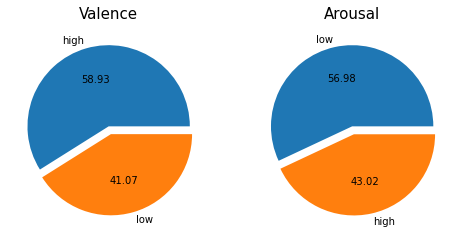

In [12]:

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (8,4))

ax1.pie(x_pca['Valence(std)'].value_counts(), explode = [0,0.1], labels=['high', 'low'],autopct="%0.2f")
ax1.set_title('Valence',fontsize=15)

ax2.pie(x_pca['Arousal(std)'].value_counts(), explode = [0,0.1], labels=['low', 'high'],autopct="%0.2f")
ax2.set_title('Arousal',fontsize=15)

plt.show()

In [13]:
lyrics.head()

,musicId,lrc_text,Arousal(mean),Valence(mean)
0,755,biang biang biang biang ~. ba ba ba ba. bang b...,0.5125,0.625
1,796,Beep. Beep. I'm sittin' at the red light. My a...,0.6000,0.375
2,966,"""Law"" (feat. E-40). -. Don't ******* no ******...",0.5750,0.450
3,225,"Oh, oh, oh, oh. I've been hurt so many times. ...",0.4125,0.525
4,219,I took 2 weeks vacation. for the honey moon. A...,0.8375,0.750


In [14]:
ps = PorterStemmer()

def transform_text(text):
    """
    This function takes a string of text and preprocesses it for NLP analysis.
    It converts the text to lowercase, tokenizes the text, 
    removes non-alphanumeric characters, removes stop words and punctuation, 
    and applies stemming to the remaining words.
    """
        # Convert the text to lowercase
    text = text.lower()

    # Tokenize the text
    text = nltk.word_tokenize(text)

    # Remove non-alphanumeric characters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    # Update the text with the alphanumeric words
    text = y[:]
    y.clear()

    # Remove stop words and punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    # Update the text with the words that are not stop words or punctuation
    text = y[:]
    y.clear()

    # Apply stemming to the words
    for i in text:
        y.append(ps.stem(i))

    # Join the stemmed words into a single string and return it
    return " ".join(y)


In [15]:
lyrics['new_transformed_text'] = lyrics['lrc_text'].apply(transform_text)
lyrics.drop(columns=['lrc_text','Arousal(mean)','Valence(mean)'],inplace = True)
lyrics.head(2)

,musicId,new_transformed_text
0,755,biang biang biang biang ba ba ba ba bang bang ...
1,796,beep beep sittin red light ankl monitor beepin...


In [16]:
lyrics = pd.merge(data, lyrics, on=['musicId'])
print(lyrics.shape)
lyrics.head(2)

(601, 6377)


,musicId,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,...,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,Arousal(std),Valence(std),new_transformed_text
0,1,7.318236,0.716432,0.0,2.245124,3.145057,3.956726,0.899933,0.811669,1.711601,...,2.886936,-1339.063,0.554930,113.5535,57.37954,111.6133,59.35901,0.156125,0.160078,uhh yeah alright hahah yeah use treat mattress...
1,5,8.152512,0.368032,0.0,1.404577,1.969597,2.666271,0.565020,0.696674,1.261694,...,2.421824,2630.371,0.550189,105.5406,53.73272,105.5167,54.68540,0.175000,0.203101,hook young savag trappin hard nigga cappin har...


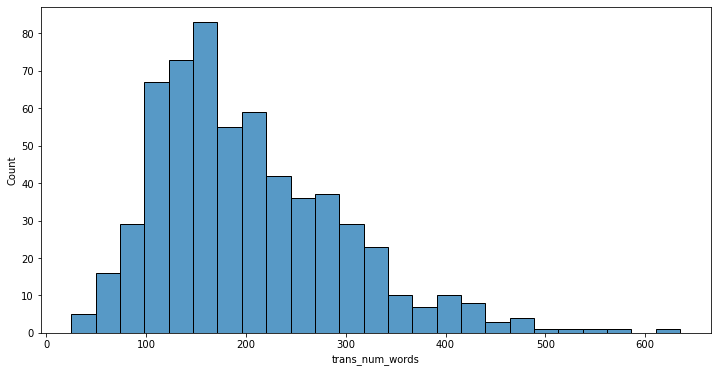

In [17]:
lyrics['trans_num_words'] = lyrics['new_transformed_text'].apply(lambda x:len(nltk.word_tokenize(x)))
plt.figure(figsize=(12,6))
sns.histplot(lyrics['trans_num_words'],bins= 25)
plt.show()

In [18]:
lyrics = lyrics[['new_transformed_text','musicId']]
df = pd.merge(x_pca, lyrics, on=['musicId'])
print(df.shape)
df.head(2)

(601, 442)


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_432,Feature_433,Feature_434,Feature_435,Feature_436,Feature_437,musicId,Valence(std),Arousal(std),new_transformed_text
0,41.266488,-10.954914,-7.580765,7.477240,12.851321,1.761903,-10.045591,-14.496956,-0.433863,-7.156038,...,-0.970757,-0.384662,1.844554,1.676952,0.007355,0.014280,1,1,1,uhh yeah alright hahah yeah use treat mattress...
1,61.019710,4.158902,19.904441,-20.372645,-11.279471,8.182206,12.708800,-12.923083,-7.058927,-4.969211,...,0.460993,-1.931072,2.134956,0.335046,0.320404,-1.254232,5,1,1,hook young savag trappin hard nigga cappin har...


In [19]:
df.isna().sum()

Feature_0               0
Feature_1               0
Feature_2               0
Feature_3               0
Feature_4               0
                       ..
Feature_437             0
musicId                 0
Valence(std)            0
Arousal(std)            0
new_transformed_text    0
Length: 442, dtype: int64

In [20]:
df.duplicated().sum()

0

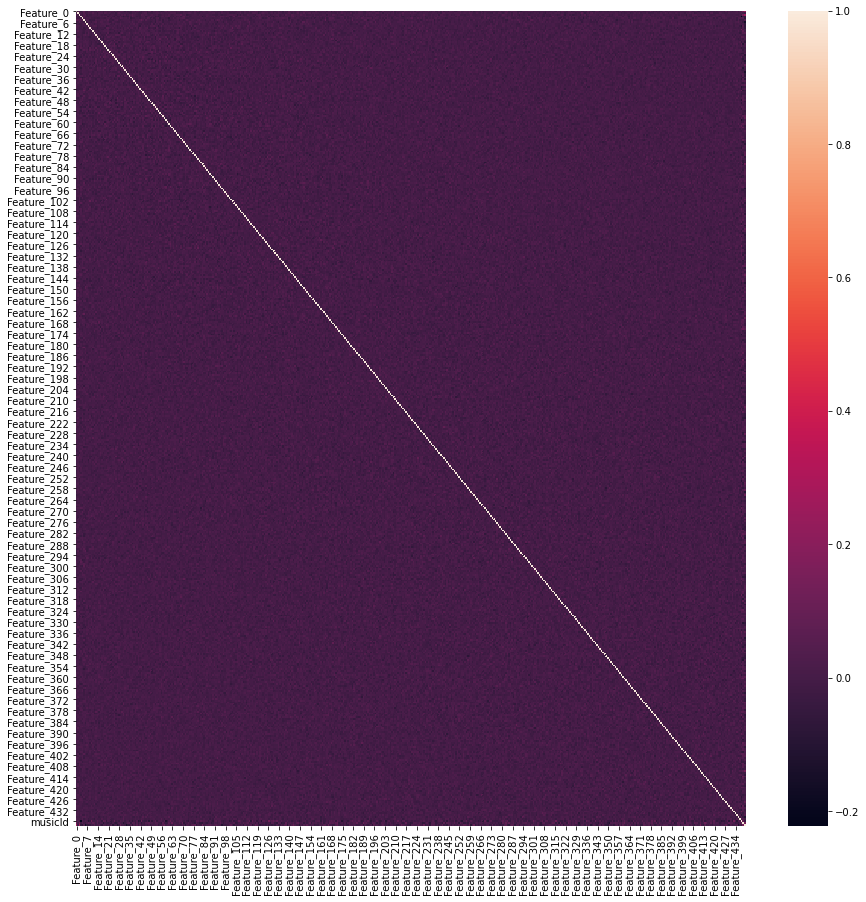

In [21]:
plt.figure(figsize = (15,15))
sns.heatmap(df.corr())
plt.show()

In [22]:
df.corr()['Valence(std)'].sort_values(ascending = False).head(10)

Valence(std)    1.000000
Arousal(std)    0.139212
Feature_0       0.129859
Feature_2       0.119218
Feature_414     0.110953
Feature_189     0.110918
Feature_172     0.098027
Feature_63      0.096313
Feature_361     0.090394
musicId         0.083587
Name: Valence(std), dtype: float64

In [23]:
def word_embedding(lyrics, max_words=None, max_len=None, verbose=True):
    
    # Tokenize the lyrics using the Tokenizer method, and limit the number of words to max_words
    tok = Tokenizer(num_words=max_words)
    tok.fit_on_texts(lyrics)
    
    # Convert the tokenized lyrics to sequences of integers
    sequences = tok.texts_to_sequences(lyrics)
    
    # Pad the sequences to ensure they all have the same length (max_len)
    sequences_matrix = pad_sequences(sequences,maxlen=max_len)
    
    # Print the shape of the features (sequences_matrix) and the number of words in the tokenized lyrics
    if verbose:
        print('Features shape :',sequences_matrix.shape)
        print('No. of words :',len(tok.word_index))
    
    # Return the padded sequences as the feature data
    return sequences_matrix


In [24]:

max_words = 1000
max_len = 150

sequences_matrix = word_embedding(max_words = max_words,
                                  max_len = max_len, 
                                  lyrics=df['new_transformed_text'])


Features shape : (601, 150)
No. of words : 7548


In [25]:

# This function prepares the data for modeling by combining the lyrics and audio features and the target variable
def pre_data(y):
    
    # Get the target variable from the input DataFrame (df) and convert it to a numpy array
    y = np.array(df[y])
    
    # Get the lyrics feature data (sequences_matrix) and convert it to a numpy array
    lyrics_x = sequences_matrix
    
    # Get the audio feature data by dropping the irrelevant columns (Arousal(std), Valence(std), musicId, new_transformed_text)
    audio_x = df.drop(columns = ['Arousal(std)','Valence(std)','musicId','new_transformed_text'])
    audio_x  = np.array(audio_x)
    
    # Print the shape of the audio feature data
    print(audio_x.shape)
    
    # Create dataframes for the lyrics feature data, audio feature data, and target variable
    d1 = pd.DataFrame(lyrics_x)
    d2 = pd.DataFrame(audio_x)
    d3 = pd.DataFrame(y)

    # Concatenate the three dataframes along the columns (axis=1) to create the final data for modeling
    final_data = pd.concat([d1,d2,d3],axis = 1)
    
    # Return the final data for modeling
    return final_data


In [27]:
# This function splits the data into train and test sets for modeling
def data_split(data,test_size,random_state, verbose = True):
    
    # Shuffle the data and split into train and test sets based on the test_size and random_state parameters
    shuffle_train = data.sample(frac = 1-test_size, random_state = random_state)
    y_train = np.array(shuffle_train.iloc[:,-1])

    shuffle_test = data.sample(frac = test_size, random_state = random_state)
    y_test = np.array(shuffle_test.iloc[:,-1])
    
    # Get the lyrics feature data for the train and test sets
    lyric_train = np.array(shuffle_train.iloc[:,0:150])
    lyric_test = np.array(shuffle_test.iloc[:,0:150])
    
    # Get the audio feature data for the train and test sets
    audio_train = np.array(shuffle_train.iloc[:,150:588])
    audio_test = np.array(shuffle_test.iloc[:,150:588])
    
    # Print the shapes of the train and test sets for the lyrics, audio, and target variables
    if verbose:
        print('lyric_train :',lyric_train.shape,'lyric_test :',lyric_test.shape)
        print('audio_train :',audio_train.shape,'audio_test :',audio_test.shape)
        print('y_train :',y_train.shape,'y_test :',y_test.shape)

    # Return the train and test sets for the target variable, lyrics feature data, and audio feature data
    return y_train, y_test, lyric_train, lyric_test, audio_train, audio_test


# Valance Classification

In [26]:
valence_data = pre_data('Valence(std)')
valence_data.head(2)

(601, 438)


,0,1,2,3,4,5,6,7,8,9,...,429,430,431,432,433,434,435,436,437,0
0,552,188,33,628,44,472,178,553,213,210,...,-1.563121,1.034726,-2.809963,-0.970757,-0.384662,1.844554,1.676952,0.007355,0.014280,1
1,687,98,89,65,27,300,509,208,92,10,...,0.982883,1.479134,1.755738,0.460993,-1.931072,2.134956,0.335046,0.320404,-1.254232,1


In [28]:
y_train,y_test,lyric_train,lyric_test,audio_train,audio_test = data_split(data=valence_data,test_size = 0.2,random_state = 48, verbose = True)

lyric_train : (481, 150) lyric_test : (120, 150)
audio_train : (481, 438) audio_test : (120, 438)
y_train : (481,) y_test : (120,)


In [29]:
def train(x_train, y_train, x_test, y_test):
    classifiers = [
        ("KNeighborsClassifier", KNeighborsClassifier()),
        ("LogisticRegression", LogisticRegression(max_iter=1000)),
        ("DecisionTreeClassifier", DecisionTreeClassifier()),
        ("RandomForestClassifier", RandomForestClassifier()),
        ("GradientBoostingClassifier", GradientBoostingClassifier()),
        ("SVC", SVC(probability=True)),
        ("GaussianNB", GaussianNB())
    ]

    for clf_name, clf in classifiers:
        clf.fit(x_train, y_train)
        test_accuracy = clf.score(x_test, y_test)
        train_accuracy = clf.score(x_train, y_train)

        print(f"{clf_name} test Accuracy: {test_accuracy}")
        print(f"{clf_name} train Accuracy: {train_accuracy}")
        print('-----------------------------------------------------------------------')

### Valance Classification on Audio Data

In [43]:
train(audio_train,y_train,audio_test,y_test)

KNeighborsClassifier test Accuracy: 0.6666666666666666
KNeighborsClassifier train Accuracy: 0.7089397089397089
-----------------------------------------------------------------------
LogisticRegression test Accuracy: 1.0
LogisticRegression train Accuracy: 1.0
-----------------------------------------------------------------------
DecisionTreeClassifier test Accuracy: 1.0
DecisionTreeClassifier train Accuracy: 1.0
-----------------------------------------------------------------------
RandomForestClassifier test Accuracy: 1.0
RandomForestClassifier train Accuracy: 1.0
-----------------------------------------------------------------------
GradientBoostingClassifier test Accuracy: 1.0
GradientBoostingClassifier train Accuracy: 1.0
-----------------------------------------------------------------------
SVC test Accuracy: 0.775
SVC train Accuracy: 0.8648648648648649
-----------------------------------------------------------------------
GaussianNB test Accuracy: 0.5916666666666667
Gaussian

### Valance Classification on Lyrics Data

In [44]:
train(lyric_train,y_train,lyric_test,y_test)

KNeighborsClassifier test Accuracy: 0.7416666666666667
KNeighborsClassifier train Accuracy: 0.7338877338877339
-----------------------------------------------------------------------
LogisticRegression test Accuracy: 0.775
LogisticRegression train Accuracy: 0.7796257796257796
-----------------------------------------------------------------------
DecisionTreeClassifier test Accuracy: 1.0
DecisionTreeClassifier train Accuracy: 0.9958419958419958
-----------------------------------------------------------------------
RandomForestClassifier test Accuracy: 1.0
RandomForestClassifier train Accuracy: 0.9958419958419958
-----------------------------------------------------------------------
GradientBoostingClassifier test Accuracy: 0.9916666666666667
GradientBoostingClassifier train Accuracy: 0.9937629937629938
-----------------------------------------------------------------------
SVC test Accuracy: 0.9333333333333333
SVC train Accuracy: 0.9334719334719335
-----------------------------------

### Keras Functional Model which can handle multiple input output

In [50]:

def model():
    # Layer 1
    input_1 = Input(shape =[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(input_1)
    layer = LSTM(150,activation='relu',return_sequences=False,kernel_initializer="he_normal")(layer)
    layer = BatchNormalization()(layer)
    layer = Dense(256, activation='relu',kernel_initializer="he_normal")(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(128, activation='relu',kernel_initializer="he_normal")(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(64, activation='relu',kernel_initializer="he_normal")(layer)
    layer = Model(inputs = input_1, outputs = layer)
    
    # Layer 2
    input_2 = Input(shape =(438))
    layer2 = Dense(512,activation='relu',kernel_initializer="he_normal")(input_2)
    layer2 = BatchNormalization()(layer2)
    layer2 = Dropout(0.3)(layer2)
    layer2 = Dense(256,activation='relu',kernel_initializer="he_normal")(layer2)
    layer2 = BatchNormalization()(layer2)
    layer2 = Dropout(0.3)(layer2)
    layer2 = Dense(64,activation='relu',kernel_initializer="he_normal")(layer2)
    layer2 = Model(inputs = input_2, outputs = layer2)

    combined = Concatenate()([layer.output, layer2.output])

    layer3 = Dense(64,activation='relu')(combined)
    layer3 = Dense(1,activation='sigmoid')(layer3)

    model = Model(inputs=[layer.input, layer2.input], outputs=layer3)
    model.summary()
    
    return model


In [35]:
valance_model = model()
plot_model(valance_model,show_shapes=True, show_layer_names=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 50)      50000       ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 150)          120600      ['embedding[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 150)         600         ['lstm[0][0]']                   
 alization)                                                                                 

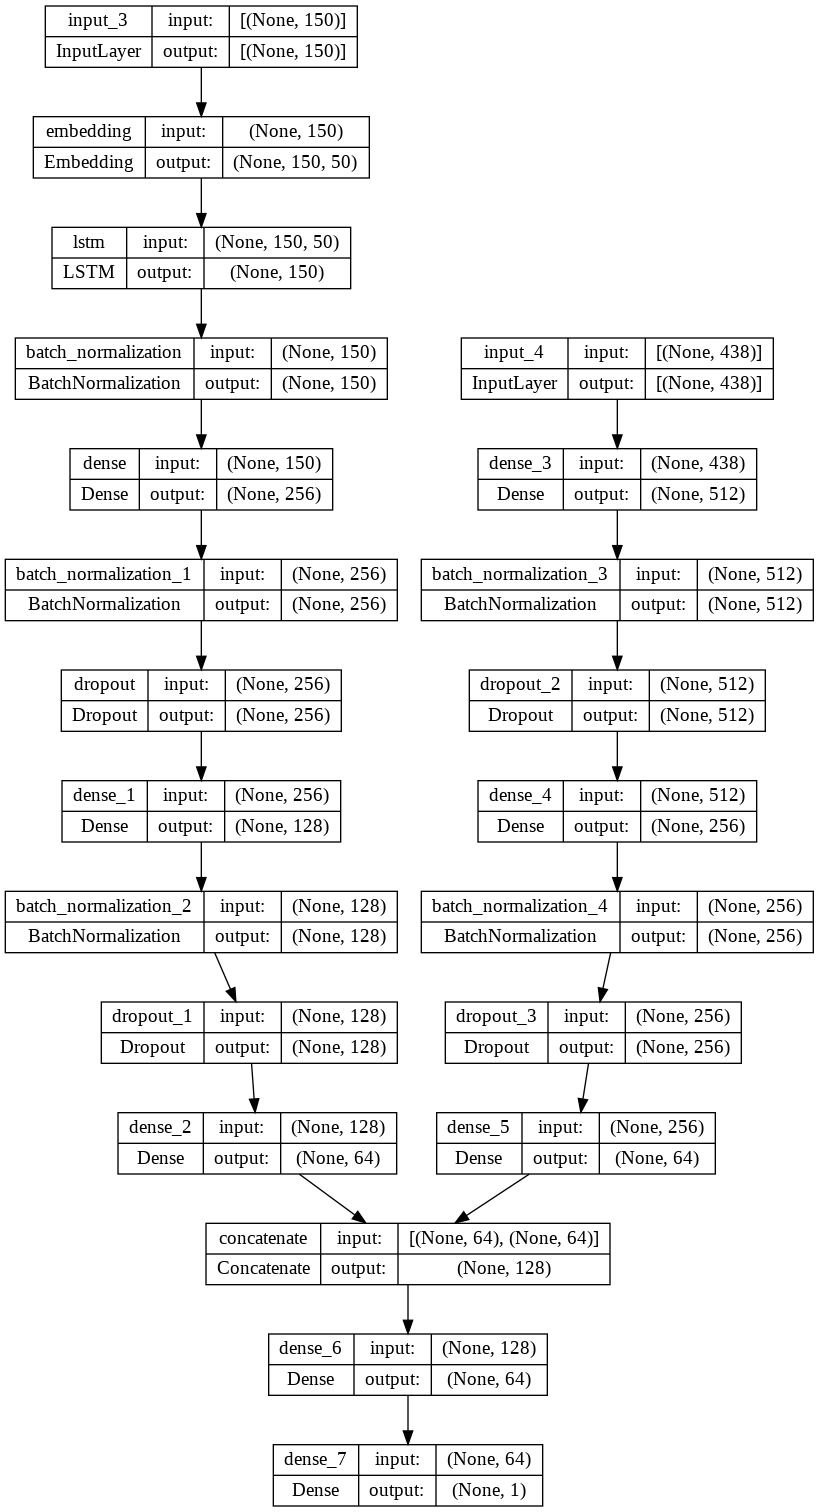

In [36]:
valance_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

history = valance_model.fit([lyric_train,audio_train],y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data = ([lyric_test,audio_test],y_test))

Epoch 1/10
16/16 [==============================] - 20s 628ms/step - loss: 0.8676 - accuracy: 0.4990 - val_loss: 0.5845 - val_accuracy: 0.7000
Epoch 2/10
16/16 [==============================] - 9s 537ms/step - loss: 0.5393 - accuracy: 0.7526 - val_loss: 0.4838 - val_accuracy: 0.7667
Epoch 3/10
16/16 [==============================] - 9s 542ms/step - loss: 0.3868 - accuracy: 0.8649 - val_loss: 0.3785 - val_accuracy: 0.8750
Epoch 4/10
16/16 [==============================] - 8s 528ms/step - loss: 0.2873 - accuracy: 0.9231 - val_loss: 0.2971 - val_accuracy: 0.9000
Epoch 5/10
16/16 [==============================] - 9s 545ms/step - loss: 0.1879 - accuracy: 0.9418 - val_loss: 0.2197 - val_accuracy: 0.9417
Epoch 6/10
16/16 [==============================] - 8s 527ms/step - loss: 0.0914 - accuracy: 0.9813 - val_loss: 0.1898 - val_accuracy: 0.9417
Epoch 7/10
16/16 [==============================] - 9s 532ms/step - loss: 0.0588 - accuracy: 0.9896 - val_loss: 0.1403 - val_accuracy: 0.9500
Epoch

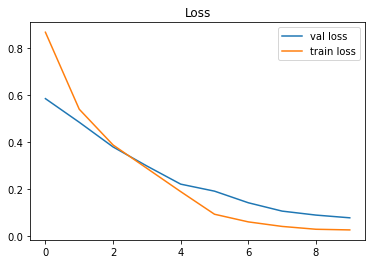

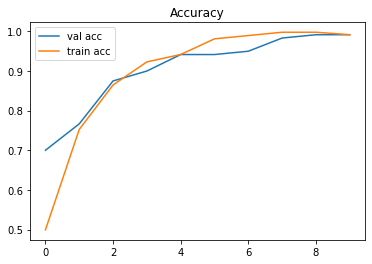

In [38]:
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['accuracy'], label='train acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [39]:
valance_model.evaluate([lyric_test,audio_test],y_test)

4/4 [==============================] - 1s 170ms/step - loss: 0.0761 - accuracy: 0.9917


[0.07612928003072739, 0.9916666746139526]

In [40]:
def model_evaluation(model,lyric_test,audio_test,y_test):
    
    # Make predictions using the model
    y_pred = model.predict([lyric_test,audio_test],verbose = 0)
    
    # Threshold the predicted values to get binary predictions
    temp_y = [1 if i > 0.5 else 0 for i in y_pred]
                
    # Print the classification report for the test set
    print(classification_report(temp_y,y_test))
    
    # Plot the confusion matrix for the test set
    plt.figure(figsize=(12,6))
    ax = sns.heatmap(tensorflow.math.confusion_matrix(
        temp_y,
        y_test,
        dtype=tf.dtypes.int32,),annot = True,fmt="d")
    
    ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
    ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

    ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
    ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
    ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.99      0.99        67

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



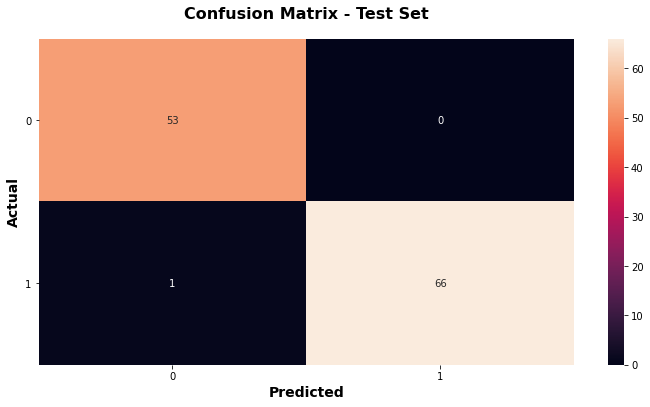

In [41]:
model_evaluation(valance_model,lyric_test,audio_test,y_test)

# Arousal Classification

In [45]:
aurosal_data = pre_data('Arousal(std)')
aurosal_data.head()

(601, 438)


,0,1,2,3,4,5,6,7,8,9,...,429,430,431,432,433,434,435,436,437,0
0,552,188,33,628,44,472,178,553,213,210,...,-1.563121,1.034726,-2.809963,-0.970757,-0.384662,1.844554,1.676952,0.007355,0.014280,1
1,687,98,89,65,27,300,509,208,92,10,...,0.982883,1.479134,1.755738,0.460993,-1.931072,2.134956,0.335046,0.320404,-1.254232,1
2,229,44,152,440,102,821,152,377,358,601,...,-0.072095,3.277523,-1.747980,1.256824,-1.141631,2.431260,-1.110024,0.188529,-0.416315,1
3,89,120,274,16,89,120,97,229,183,339,...,-0.335659,1.434034,-0.673122,-2.152849,0.943353,-2.260898,-1.742389,-0.776851,-1.093313,1
4,14,31,21,215,20,14,29,24,20,823,...,0.409308,-0.007681,-2.805164,-0.954578,-1.174092,-0.510588,1.059000,-1.448492,2.201799,1


In [46]:
y_train,y_test,lyric_train,lyric_test,audio_train,audio_test = data_split(data=aurosal_data,test_size = 0.2,random_state = 48, verbose = True)

lyric_train : (481, 150) lyric_test : (120, 150)
audio_train : (481, 438) audio_test : (120, 438)
y_train : (481,) y_test : (120,)


### Arousal classification on Audio data

In [47]:
train(audio_train,y_train,audio_test,y_test)

KNeighborsClassifier test Accuracy: 0.725
KNeighborsClassifier train Accuracy: 0.7214137214137214
-----------------------------------------------------------------------
LogisticRegression test Accuracy: 1.0
LogisticRegression train Accuracy: 1.0
-----------------------------------------------------------------------
DecisionTreeClassifier test Accuracy: 1.0
DecisionTreeClassifier train Accuracy: 1.0
-----------------------------------------------------------------------
RandomForestClassifier test Accuracy: 1.0
RandomForestClassifier train Accuracy: 1.0
-----------------------------------------------------------------------
GradientBoostingClassifier test Accuracy: 1.0
GradientBoostingClassifier train Accuracy: 1.0
-----------------------------------------------------------------------
SVC test Accuracy: 0.875
SVC train Accuracy: 0.893970893970894
-----------------------------------------------------------------------
GaussianNB test Accuracy: 0.6666666666666666
GaussianNB train Accur

### Arousal classification in Lyrics data

In [48]:
train(lyric_train,y_train,lyric_test,y_test)

KNeighborsClassifier test Accuracy: 0.675
KNeighborsClassifier train Accuracy: 0.6694386694386695
-----------------------------------------------------------------------
LogisticRegression test Accuracy: 0.8416666666666667
LogisticRegression train Accuracy: 0.8066528066528067
-----------------------------------------------------------------------
DecisionTreeClassifier test Accuracy: 1.0
DecisionTreeClassifier train Accuracy: 0.9958419958419958
-----------------------------------------------------------------------
RandomForestClassifier test Accuracy: 1.0
RandomForestClassifier train Accuracy: 0.9958419958419958
-----------------------------------------------------------------------
GradientBoostingClassifier test Accuracy: 0.9916666666666667
GradientBoostingClassifier train Accuracy: 0.9937629937629938
-----------------------------------------------------------------------
SVC test Accuracy: 0.9
SVC train Accuracy: 0.8918918918918919
--------------------------------------------------

In [51]:
aurosal_model = model()
plot_model(aurosal_model,show_shapes=True, show_layer_names=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 150, 50)      50000       ['input_3[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 150)          120600      ['embedding_1[0][0]']            
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 150)         600         ['lstm_1[0][0]']                 
 rmalization)                                                                               

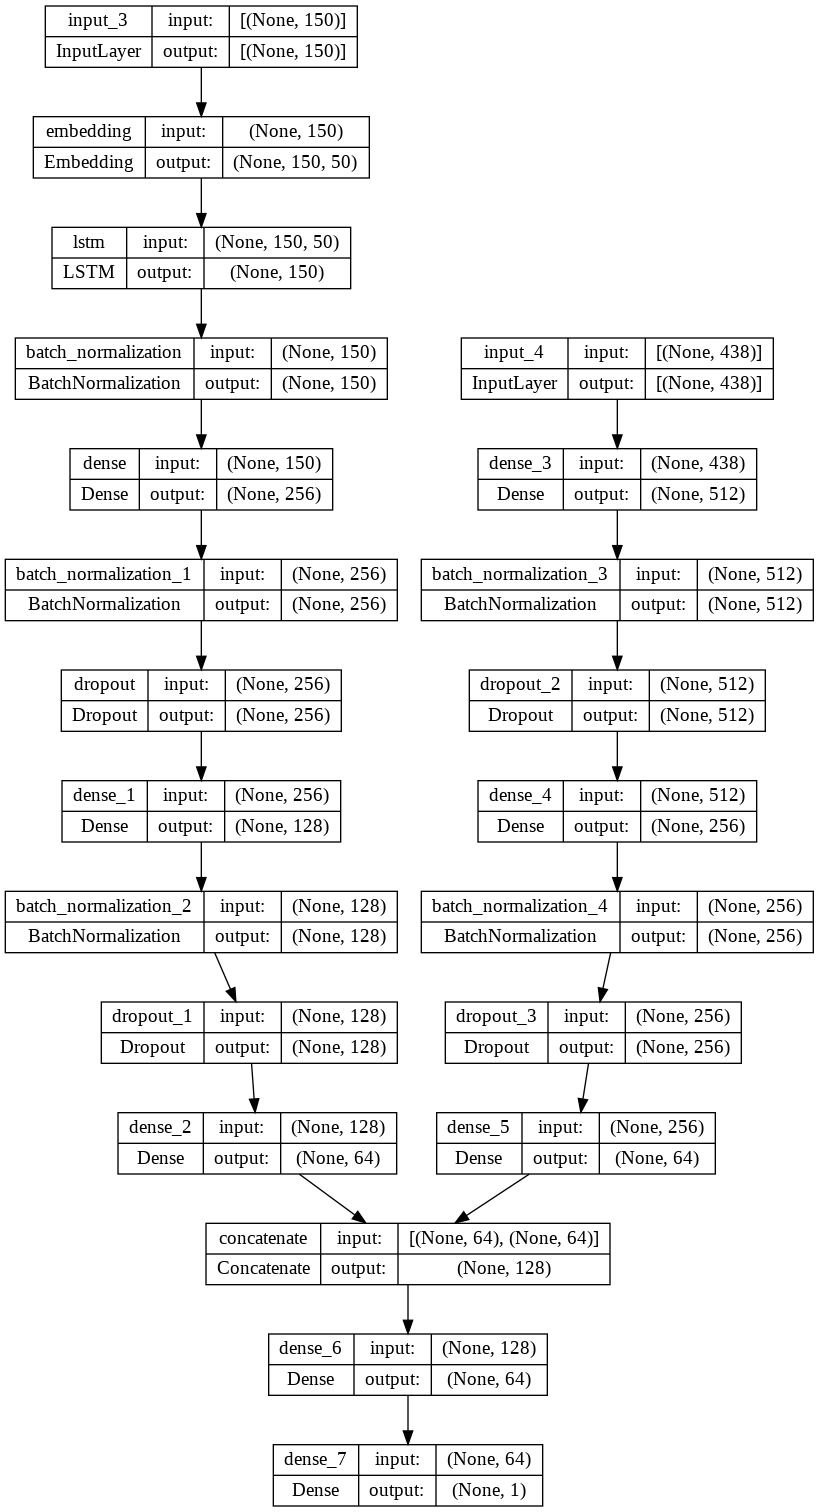

In [52]:
aurosal_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

history = aurosal_model.fit([lyric_train,audio_train],y_train,batch_size=32,epochs=10,validation_data = ([lyric_test,audio_test],y_test))

Epoch 1/10
16/16 [==============================] - 20s 668ms/step - loss: 0.7055 - accuracy: 0.5655 - val_loss: 0.5793 - val_accuracy: 0.7250
Epoch 2/10
16/16 [==============================] - 10s 629ms/step - loss: 0.5011 - accuracy: 0.7630 - val_loss: 0.5072 - val_accuracy: 0.7667
Epoch 3/10
16/16 [==============================] - 9s 581ms/step - loss: 0.3661 - accuracy: 0.8649 - val_loss: 0.3421 - val_accuracy: 0.8750
Epoch 4/10
16/16 [==============================] - 9s 588ms/step - loss: 0.2308 - accuracy: 0.9272 - val_loss: 0.2032 - val_accuracy: 0.9333
Epoch 5/10
16/16 [==============================] - 9s 540ms/step - loss: 0.1329 - accuracy: 0.9605 - val_loss: 0.1608 - val_accuracy: 0.9667
Epoch 6/10
16/16 [==============================] - 9s 539ms/step - loss: 0.0810 - accuracy: 0.9813 - val_loss: 0.1258 - val_accuracy: 0.9500
Epoch 7/10
16/16 [==============================] - 9s 539ms/step - loss: 0.0549 - accuracy: 0.9896 - val_loss: 0.0935 - val_accuracy: 0.9583
Epoc

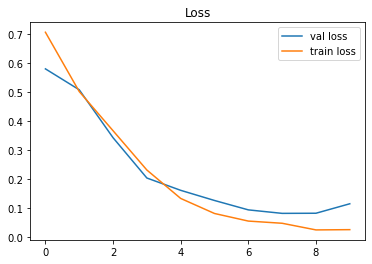

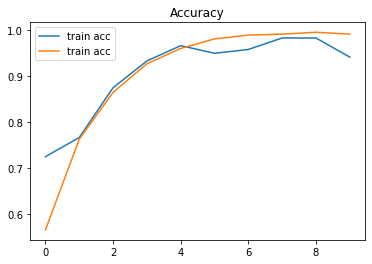

In [53]:
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(history.history['val_accuracy'], label='train acc')
plt.plot(history.history['accuracy'], label='train acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [54]:
aurosal_model.evaluate([lyric_test,audio_test],y_test)

4/4 [==============================] - 1s 160ms/step - loss: 0.1145 - accuracy: 0.9417


[0.11452154070138931, 0.9416666626930237]

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        66
           1       0.91      0.96      0.94        54

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120



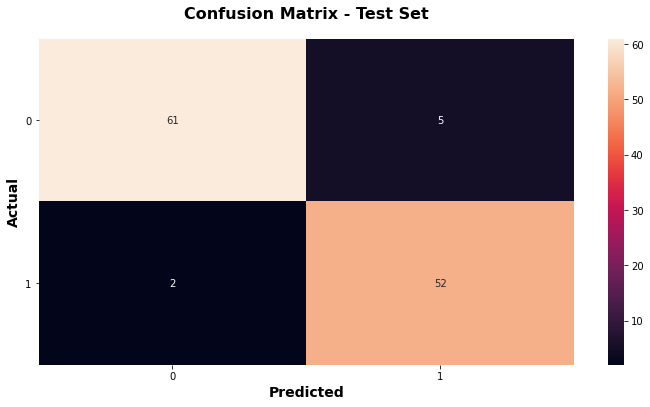

In [55]:
model_evaluation(aurosal_model,lyric_test,audio_test,y_test)